In [1]:
import cv2 as cv
import numpy as np  
import random
import math
import time
from matplotlib import pyplot as plt
import time
import gc

In [2]:
global CannyPara
global RANSACIterationN,RANSACe1,RANSACThresholdRatio

CannyPara = [100,350]

RANSACIterationN = 50000
RANSACe1 = 6
RANSACe2 = 3

#performace
global pBarLength

pBarLength = 30

In [3]:
def EdgeExtraction(t1, t2, img): #Perform Canny Edge Detection
    imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    imgGaussian = cv.GaussianBlur(imgGray,(3,3),10)
    imgCanny = cv.Canny(imgGaussian,t1,t2)

    # plt
    # plt.subplot(2,1,1)
    # plt.imshow(imgCanny,cmap="gray")
    # plt.title("Edge Image")
    return imgCanny

In [4]:
def RandomPointsGenerate(validPoints,imgSize): #select 3 point according to the edge image
    points = []
    #obtain 3 point from validPoint
    points = random.sample(validPoints,3)

    
    if CollinearityCheck(points) and points != None:
        return points
    else:
        # print("\nWarning: redo random point generation")
        return RandomPointsGenerate(validPoints,imgSize)

In [5]:
def CollinearityCheck(points): #Accoridng to 3 point to check the collinearent of them
    isCollinearent = False    
    # print(points)
    #(y3−y1)(x2−x1)−(y2−y1)(x3−x1)=0 
    temp = (points[2][1] - points[0][1])*(points[1][0] - points[0][0]) - (points[1][1]-points[0][1])*(points[2][0]-points[0][0])

    if temp != 0:
        isCollinearent = True

    return isCollinearent

In [6]:
def CircleCalculation(points, imgSize): #take in three point and return a centre by assuming they are in a cirle
    center = []
    radius = 0

    try:
        line1 = MedLineCal(points[0],points[1])
        line2 = MedLineCal(points[0],points[2])
    except:
        print("ERROR DETECTED: ",points)
    center = IntersectCal(line1,line2)
    radius = int(PointDistanceCal(points[0],center))

    if center[0] < 0 or center[0] > imgSize[1] or center[1] < 0 or center[1] > imgSize[0]:
        return None
    return [center[0],center[1],radius]

In [7]:
def MedLineCal(point1, point2): #according to 2 point return the line Eq in form Ax + By + C = 0
    A = 2 * (point2[0] - point1[0])
    B = 2 * (point2[1] - point1[1])
    C = (point1[0]**2 - point2[0]**2) + (point1[1]**2 - point2[1]**2)
    return [A,B,C]

In [8]:
def IntersectCal(line1, line2): #giving 2 line and return 1 point for their intersection
    m = line1[0]*line2[1] - line2[0]*line1[1] # m = A1*B2 - A2*B1
    if m == 0:
        print("Error: no intersection")
        return
    else:
        x = (line2[2]*line1[1] - line1[2]*line2[1]) / m #x=(C2×B1-C1×B2）/（A1×B2-A2×B1）
        y = (line1[2]*line2[0] - line2[2]*line1[0]) / m #y=(C1×A2-C2×A1）/（A1×B2-A2×B1）
    return[int(x),int(y)]

In [9]:
def PointDistanceCal(point1, point2):
    return math.sqrt(pow((point2[0] - point1[0]),2) + pow((point2[1] - point1[1]),2))

In [10]:
def ObtainValidPoints(img):
    vaildPoints = np.where(img != [0])
    vaildPoints = list(zip(vaildPoints[0],vaildPoints[1]))
    return vaildPoints

center [384, 514]
radius 360


<Figure size 1800x1200 with 0 Axes>

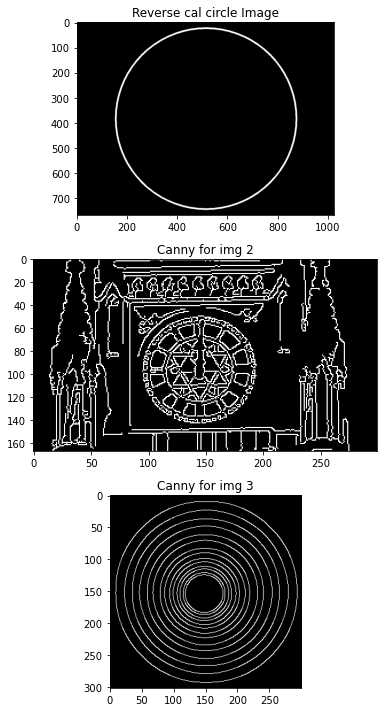

In [11]:


imgName = "circle.jpg"
img = cv.imread(imgName)
img2 = cv.imread("parliament_clock.jpg")
img3 = cv.imread("concentric_circles.jpg")

imgSize = [img.shape[0],img.shape[1]]
points = []
circle = []

imgEmpty = np.zeros((imgSize[0],imgSize[1]),dtype=np.uint8)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img)
vaildPoints = ObtainValidPoints(imgEdge)
points = RandomPointsGenerate(vaildPoints,imgSize)
circle = CircleCalculation(points,imgSize)
while not circle:
    points = RandomPointsGenerate(vaildPoints,imgSize)
    circle = CircleCalculation(points,imgSize)
print("center",[circle[0],circle[1]])
print("radius",circle[2])

plt.figure(dpi=300)
plt.figure(figsize=(10,10))
cv.circle(imgEmpty,(circle[1],circle[0]),circle[2],(255,255,255),RANSACe1)
plt.subplot(3,1,1)
plt.imshow(imgEmpty, cmap="gray")
plt.title("Reverse cal circle Image")

plt.subplot(3,1,2)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img2)
plt.imshow(imgEdge, cmap="gray")
plt.title("Canny for img 2")

plt.subplot(3,1,3)
imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img3)
plt.imshow(imgEdge, cmap="gray")
plt.title("Canny for img 3")
plt.tight_layout()

1.3

In [12]:
def RANSACAlgorithm(imgEdge,imgSize,RANSACThresholdRatio):
    #Required init 
    iteratNum = 0
    maxCountNum = -1
    bestCircle = (0,0,0)
    bestRatio = 0
    bestInlier = []

    # validPoints = ObtainValidPoints(imgEdge)
    vaildPoints = np.where(imgEdge != [0])  
    vaildPoints = list(zip(vaildPoints[0],vaildPoints[1]))
    vaildPoints = set(vaildPoints)
    #Custom Init
    
    
    clock3 = 0
    while iteratNum < RANSACIterationN:


        # time1 = time.time()

        #obtain param
        k = 0
        ratio = 0
        points = RandomPointsGenerate(vaildPoints,imgSize)
         
        tempCirclePara = CircleCalculation(points, imgSize)
        if not tempCirclePara:
            # print("\nDrop")
            continue

        tempCircle = np.zeros(imgSize,dtype=np.uint8)
        cv.circle(tempCircle,(tempCirclePara[1],tempCirclePara[0]),tempCirclePara[2],(255,255,255),RANSACe1)
        time3 = time.time()
        edgeImgPoint = np.where(tempCircle != 0)
        edgeImgPoint = set(list(zip(edgeImgPoint[0],edgeImgPoint[1])))
        # k = list(filter(lambda a:a in vaildPoints,edgeImgPoint))
        k = vaildPoints.intersection(edgeImgPoint)
        time4 = time.time()
        ratio = len(k) / len(edgeImgPoint)
        iteratNum += 1

        #check update
        if ratio > bestRatio and len(k) > maxCountNum:
            print("\n"+10*'!',"UPDATE",10*'!')
            bestCircle = tempCirclePara
            maxCountNum = len(k)
            bestRatio = ratio
            bestInlier = list(k)
        
        if ratio > RANSACThresholdRatio:
            print("\n"+20*"*","Reach RANSEC Threshold, break loop",20*"*") 
            print("k = ",maxCountNum)
            print("ratio = ",ratio)
            print("circle = ",bestCircle)
            break
        # time5 = time.time()


        # Performance
        # clock1 = time2 - time1
        # clock2 = time3 - time2
        # clock3 += time4 - time3
        # clock4 = time5 - time4
        # print("\n\nI = ",iteratNum,"\ntime1 = ",str(clock1),"\ntime2 = ",str(clock2),"\ntime3 = ",str(clock3),"\ntime4 = ",str(clock4))
        # if iteratNum % 200 == 0:
        #     temp = clock3 / 200
        #     print("\nAVG ",temp)
        
        pctge = iteratNum / RANSACIterationN
        temp = int(round(pBarLength * pctge))
        print('\r%s%s%s%s%s%s%s%s'% ((temp)*'█',(pBarLength-temp)*'░',str(round(pctge*100)),'%',"\tIteration = ",str(iteratNum),"   \tBest: "+str(bestCircle),"\tRatio ="+str(round(bestRatio,5))),end=' ')
        
    return bestCircle,bestInlier,iteratNum
    

In [13]:
def PostProcessing(validCirclePoint):
    
    meanCenter = np.mean(validCirclePoint,axis=0)
    meanRadius = []
    for point in validCirclePoint:
        meanRadius.append(PointDistanceCal(point,meanCenter))
    meanRadius = np.mean(meanRadius)
    temp = (int(meanCenter[0]),int(meanCenter[1]),int(meanRadius))
    print(40*'/'+"\nFinished, with final circle para:",str(temp)+'\n'+40*'/')

    return temp


In [14]:


def RANSACMain(imgName,RANSACThresholdRatio):
    gc.collect()
    timeS = time.time()
    print("\nSTART RANSAC for image",imgName)

    img = cv.imread(imgName)
    imgDetected = np.copy(img)
    imgSize = [img.shape[0],img.shape[1]]

    #1.3 RANSAC
    imgEdge = EdgeExtraction(CannyPara[0],CannyPara[1],img)
    bestCircle,bestInlier,iteratNum = RANSACAlgorithm(imgEdge,imgSize,RANSACThresholdRatio)
    cv.circle(img,(bestCircle[1],bestCircle[0]),bestCircle[2],(0,0,255),RANSACe1)
    cv.circle(imgDetected,(bestCircle[1],bestCircle[0]),bestCircle[2],(0,0,255),RANSACe2)

    #1.4 PostProcessing 
    print("\n Finish RANSAC, Start Post Processing")

    bestCircle = PostProcessing(bestInlier)
    timeE = time.time()
    timeDiff = timeE - timeS
    print("Interation Num = ",iteratNum, "Finished with in ",timeDiff)
    cv.circle(imgDetected,(bestCircle[1],bestCircle[0]),bestCircle[2],(0,255,0),RANSACe2)


    #1.5 Deliverable ploting
    plt.figure(dpi=300)
    plt.figure(figsize=(10,10))

    plt.subplot(2,1,1)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.title("Detected Counting Image")
    plt.subplot(2,1,2)
    plt.imshow(cv.cvtColor(imgDetected,cv.COLOR_BGR2RGB))
    plt.title("Detected Intersection Image")

    plt.tight_layout()




In [15]:
#Performance testbench 
# clock = 0
# for i in range(20):
#     timeS = time.time()
#     RANSACMain("parliament_clock.jpg")
#     timeE = time.time()
#     clock += timeE - timeS
#     print('.',end = ' ')
# temp = clock / 20
# print("AVG ",temp)


START RANSAC for image circle.jpg

!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 1   	Best: [385, 517, 358]	Ratio =0.15451 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 2   	Best: [384, 509, 364]	Ratio =0.25291 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 5   	Best: [384, 510, 362]	Ratio =0.32849 
!!!!!!!!!! UPDATE !!!!!!!!!!

******************** Reach RANSEC Threshold, break loop ********************
k =  5298
ratio =  0.3364236728473457
circle =  [383, 511, 362]

 Finish RANSAC, Start Post Processing
////////////////////////////////////////
Finished, with final circle para: (383, 511, 361)
////////////////////////////////////////
Interation Num =  6 Finished with in  0.05587148666381836


<Figure size 1800x1200 with 0 Axes>

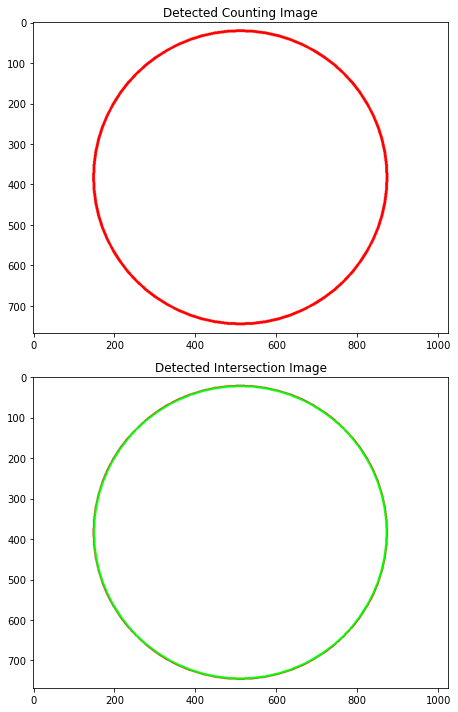

In [16]:

RANSACMain("circle.jpg",0.33)


START RANSAC for image parliament_clock.jpg

!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 1   	Best: [41, 116, 122]	Ratio =0.1283 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 8   	Best: [84, 156, 62]	Ratio =0.19852 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 60   	Best: [75, 109, 67]	Ratio =0.21365 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░1%	Iteration = 418   	Best: [93, 107, 64]	Ratio =0.22803 
!!!!!!!!!! UPDATE !!!!!!!!!!
█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░5%	Iteration = 2288   	Best: [95, 144, 45]	Ratio =0.33569 
!!!!!!!!!! UPDATE !!!!!!!!!!
██████████████████████████████100%	Iteration = 50000   	Best: [97, 145, 46]	Ratio =0.34815 
 Finish RANSAC, Start Post Processing
////////////////////////////////////////
Finished, with final circle para: (96, 143, 45)
////////////////////////////////////////
Interation Num =  50000 Finished with in  46.72530913352966


<Figure size 1800x1200 with 0 Axes>

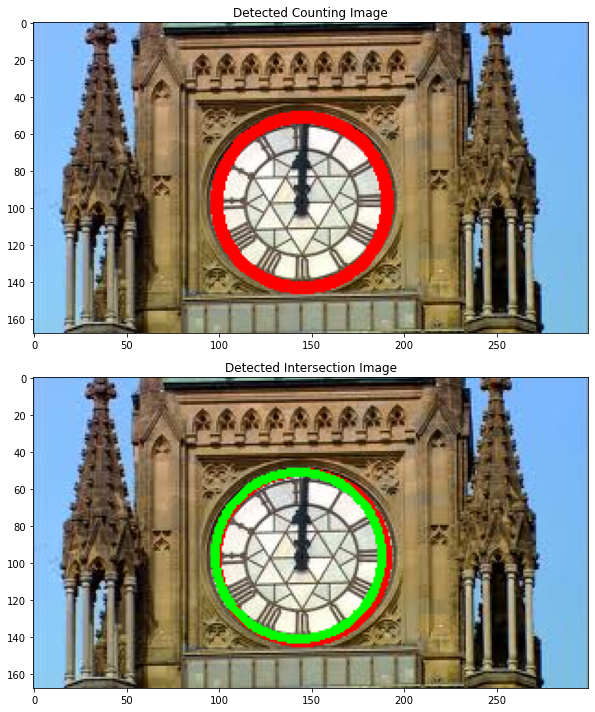

In [17]:
RANSACMain("parliament_clock.jpg",0.4)


START RANSAC for image concentric_circles.jpg

!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 7   	Best: [238, 164, 61]	Ratio =0.12363 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 126   	Best: [163, 113, 81]	Ratio =0.13282 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 165   	Best: [198, 179, 87]	Ratio =0.13499 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░0%	Iteration = 189   	Best: [151, 149, 115]	Ratio =0.16733 
!!!!!!!!!! UPDATE !!!!!!!!!!
░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░2%	Iteration = 764   	Best: [150, 149, 141]	Ratio =0.16781 
!!!!!!!!!! UPDATE !!!!!!!!!!
██████████████████████████████100%	Iteration = 50000   	Best: [151, 149, 142]	Ratio =0.16871 
 Finish RANSAC, Start Post Processing
////////////////////////////////////////
Finished, with final circle para: (150, 150, 142)
////////////////////////////////////////
Interation Num =  50000 Finished with in  59.50874328613281


<Figure size 1800x1200 with 0 Axes>

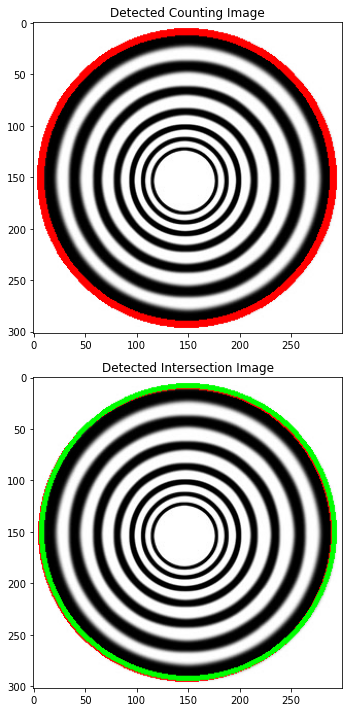

In [18]:
RANSACMain("concentric_circles.jpg",0.3)